### Kalman Filter Q1

Kalman filter is a method that estimates a hidden true signal by combining a system’s predicted behavior with noisy sensor measurements. In this code, I first simulate a real underlying process and then generate noisy observations of it, just like a sensor would in practice. The filter produces an estimate that should be closer to the true signal than the raw measurements because it balances how much it trusts the model versus how much it trusts the sensor. When measurement noise is higher, I expect the estimate to look smoother and rely more on the model; when the process noise is higher, I expect it to follow the measurements more closely. Overall, the goal of this code is to visually show that the filter can reduce noise and track the true trajectory more reliably than using measurements alone.

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def run_scalar_kf(a, b, Q, R, T, Z0=0.0, P0=1.0, Y0=0.0, seed=0):
    """
    Implements exactly the equations in the prompt:

    Update:
        Y_{n+1} = a Y_n + k_n (X_n - b Y_n)

    Gain:
        k_n = (b a P_n) / (b^2 P_n + R)

    Error variance:
        P_{n+1} = a (a - b k_n) P_n + Q

    Also simulates:
        Z_{n+1} = a Z_n + W_n
        X_n     = b Z_n + N_n
    """
    rng = np.random.default_rng(seed)

    Z = np.zeros(T + 1)
    X = np.zeros(T + 1)
    Y = np.zeros(T + 1)
    P = np.zeros(T + 1)
    K = np.zeros(T)

    Z[0] = Z0
    Y[0] = Y0
    P[0] = P0

    W = rng.normal(0.0, np.sqrt(Q), size=T)
    N = rng.normal(0.0, np.sqrt(R), size=T + 1)

    for n in range(T):
        # measurement at time n
        X[n] = b * Z[n] + N[n]

        # gain
        K[n] = (b * a * P[n]) / (b * b * P[n] + R)

        # update rule
        Y[n + 1] = a * Y[n] + K[n] * (X[n] - b * Y[n])

        # error variance recursion
        P[n + 1] = a * (a - b * K[n]) * P[n] + Q

        # true state propagation
        Z[n + 1] = a * Z[n] + W[n]

    # last measurement (optional, for plot completeness)
    X[T] = b * Z[T] + N[T]

    return Z, X, Y, P, K

# -----------------------------------------------------------
# Part A: Plot Z (unknown true), X (measurements), Y (predicted)
# for several (a,b,Q,R)
# -----------------------------------------------------------
def plot_param_sets(param_sets, T=80, base_seed=100):
    for i, (a,b,Q,R) in enumerate(param_sets, start=1):
        Z, X, Y, P, K = run_scalar_kf(a,b,Q,R,T, seed=base_seed+i)

        plt.figure()
        plt.plot(range(T+1), Z, label="True Z_n")
        plt.plot(range(T+1), X, ".", label="Measurements X_n")
        plt.plot(range(T+1), Y, "--", label="Estimate Y_n")
        plt.grid(True)
        plt.legend()
        plt.title(f"Set {i}: a={a}, b={b}, Q={Q}, R={R}")
        plt.xlabel("n")
        plt.ylabel("Value")

    plt.show()

We chose those values in param_sets_a to isolate the effect of only a and show how the Kalman filter behaves under different system dynamics. 0.7 represents a more damped and stable process, 0.9 is a typical stable case, 1.0 is a boundary-like behavior close to a random-walk style dynamic, and 1.1 represents a mildly growing, harder-to-track system. By keeping the other parameters fixed, we can clearly compare how changes in system stability and “memory” affect the filter’s estimates.

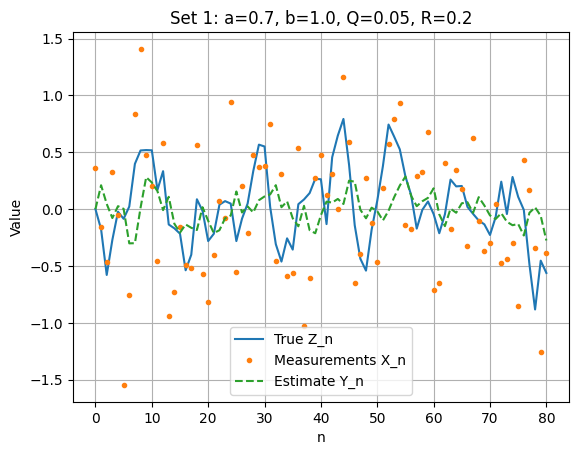

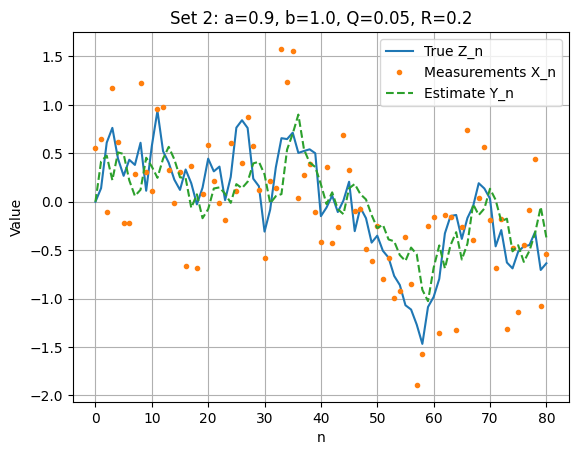

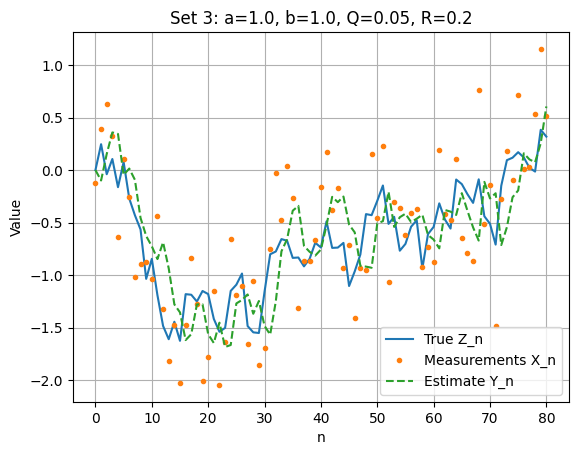

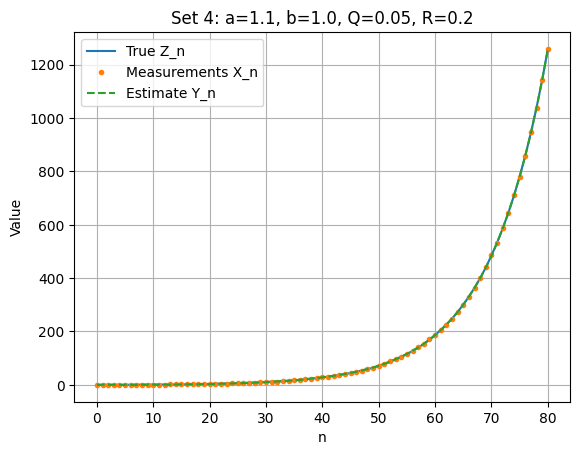

In [12]:
param_sets_a = [
    (0.7, 1.0, 0.05, 0.20),
    (0.9, 1.0, 0.05, 0.20),
    (1.0, 1.0, 0.05, 0.20),
    (1.1, 1.0, 0.05, 0.20),
]

plot_param_sets(param_sets_a)

In param_sets_b, we change only b to see the effect of the measurement scaling on the Kalman filter. Since b controls how strongly the hidden state appears in the measurement, a larger b means the sensor signal carries the state information more clearly, so the filter can extract useful information from measurements more effectively. A smaller b weakens that relationship, making measurements less informative about the true state, so the filter tends to rely relatively more on the model. By keeping a, Q, and R fixed, this setup helps us observe how measurement strength alone influences the estimation behavior.

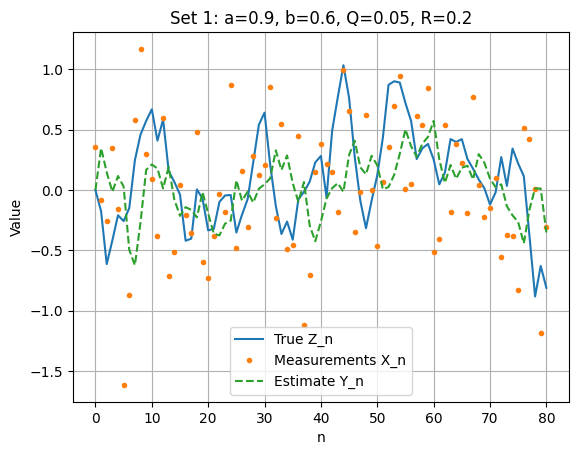

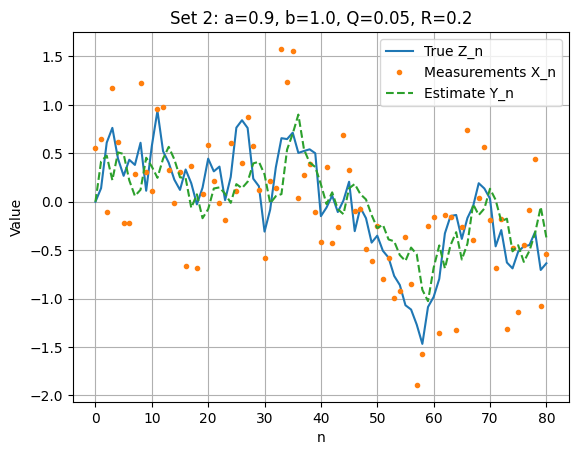

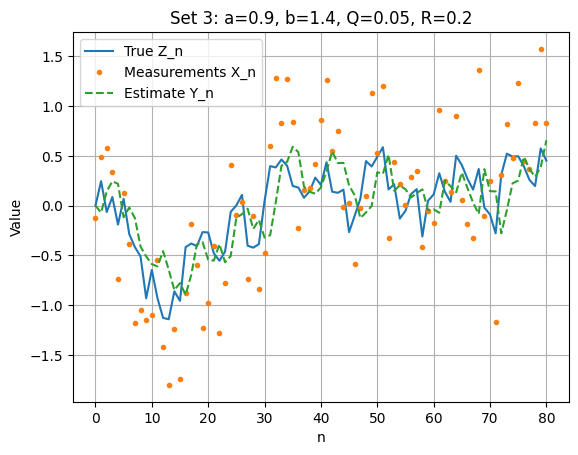

In [13]:
param_sets_b = [
    (0.9, 0.6, 0.05, 0.20),
    (0.9, 1.0, 0.05, 0.20),
    (0.9, 1.4, 0.05, 0.20),
]

plot_param_sets(param_sets_b)

We tested different values in param_sets_QR to isolate how process noise (Q) and measurement noise (R) change the Kalman filter’s trust balance between the model and the sensor. By keeping a and b fixed, we can clearly show three classic cases: a reliable sensor (small R), an unreliable/noisy sensor (large R), and an unreliable model (large Q). This makes it easy to observe how the estimate becomes smoother and more model-driven when measurements are noisy, and how it follows measurements more closely when the system itself is more unpredictable.

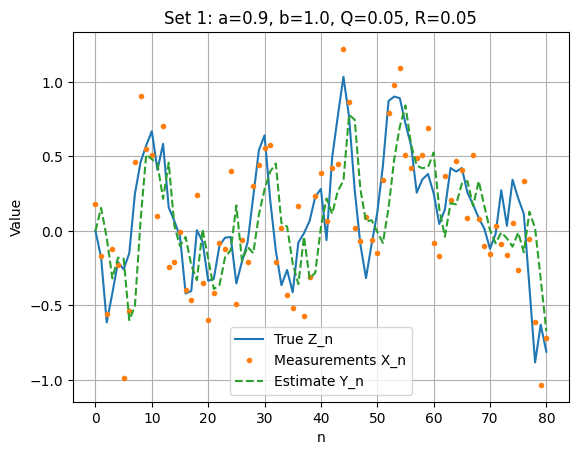

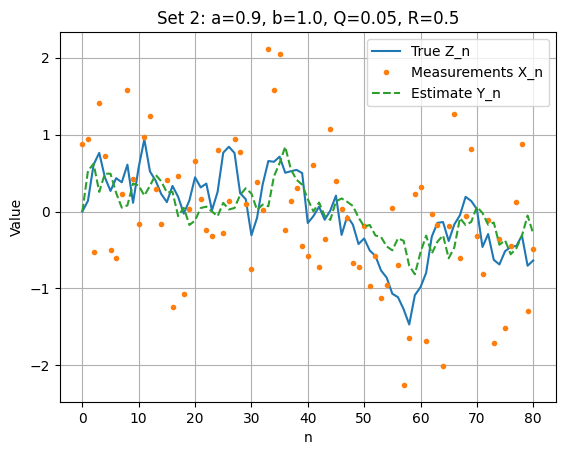

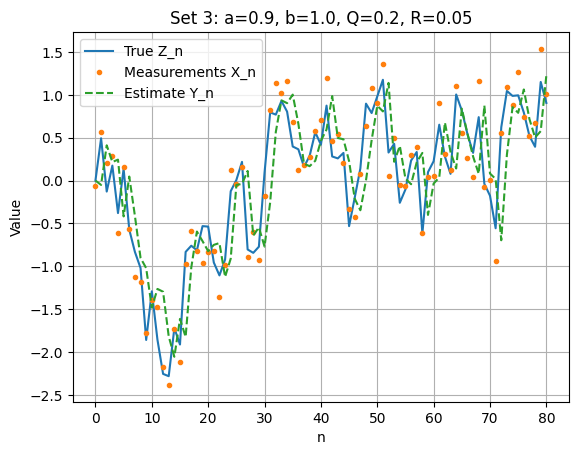

In [14]:
param_sets_QR = [
    (0.9, 1.0, 0.05, 0.05),  # good measurement (R small)
    (0.9, 1.0, 0.05, 0.50),  # bad measurement (R large)
    (0.9, 1.0, 0.20, 0.05),  # model is more noisy (Q large)
]

plot_param_sets(param_sets_QR)

Part B checks the steady-state behavior of the Kalman filter, meaning whether the gain and the estimation error variance settle to constant values as time goes to infinity. The numerical function repeatedly updates the gain and error variance for many steps starting from an initial value, so we can observe convergence to P_inf and k_inf. The closed-form function computes the same steady-state values directly from the analytical solution under constant parameters. By comparing these two results, we confirm that the filter’s long-term behavior is consistent, and we interpret the steady-state error through P_inf = E[epsilon_inf^2], sometimes also reporting \sqrt{P_\infty} for an intuitive error scale.

In [15]:
# -----------------------------------------------------------
# Part B: As n -> infinity, verify epsilon_inf and k_inf
# We interpret epsilon_inf via P_inf = E[epsilon_inf^2]
# and also print sqrt(P_inf)
# -----------------------------------------------------------

def steady_state_closed_form(a, b, Q, R):
    """
    For constant a,b,Q,R, the scalar steady-state error variance P solves:

        b^2 P^2 - (b^2 Q + R(a^2 - 1)) P - Q R = 0

    Positive root:
        P_inf = [term + sqrt(term^2 + 4 b^2 Q R)] / (2 b^2)
        term  = b^2 Q + R(a^2 - 1)

    Then:
        k_inf = (b a P_inf) / (b^2 P_inf + R)
    """
    term = b * b * Q + R * (a * a - 1.0)
    disc = term * term + 4.0 * b * b * Q * R
    P_inf = (term + np.sqrt(disc)) / (2.0 * b * b)
    k_inf = (b * a * P_inf) / (b * b * P_inf + R)
    return P_inf, k_inf


def steady_state_numerical(a, b, Q, R, P0=1.0, T=2000):
    """
    Iterates:
        k_n = (b a P_n) / (b^2 P_n + R)
        P_{n+1} = a(a - b k_n) P_n + Q
    """
    P = P0
    k = 0.0
    for _ in range(T):
        k = (b * a * P) / (b * b * P + R)
        P = a * (a - b * k) * P + Q
    return P, k

The main difference between the two curly-brace blocks is the parameter list they iterate over: the first one uses param_sets_a, while the second one uses param_sets_QR. This means the first block is designed to compare steady-state results across scenarios where the system dynamics parameter a is varied, whereas the second block compares scenarios where the noise parameters Q and R are varied while keeping the dynamics and measurement scaling mostly fixed. Apart from this change in the input set, the computations and print format are identical in both blocks, so any differences in the printed P_infinity and k_infinity values come purely from the different parameter combinations being tested.

In [16]:
print("\n--- Steady-state verification (numerical vs closed-form) ---")
for i, (a, b, Q, R) in enumerate(param_sets_a, start=1):
    P_inf_num, k_inf_num = steady_state_numerical(a, b, Q, R, P0=1.0, T=5000)
    P_inf_cf,  k_inf_cf  = steady_state_closed_form(a, b, Q, R)

    print(f"\nSet {i}: a={a}, b={b}, Q={Q}, R={R}")
    print(f"Numerical  P_inf ≈ {P_inf_num:.8f}   k_inf ≈ {k_inf_num:.8f}")
    print(f"Closed-form P_inf ≈ {P_inf_cf:.8f}   k_inf ≈ {k_inf_cf:.8f}")
    print(f"sqrt(P_inf) numerical ≈ {np.sqrt(P_inf_num):.8f}")


--- Steady-state verification (numerical vs closed-form) ---

Set 1: a=0.7, b=1.0, Q=0.05, R=0.2
Numerical  P_inf ≈ 0.07732473   k_inf ≈ 0.19517665
Closed-form P_inf ≈ 0.07732473   k_inf ≈ 0.19517665
sqrt(P_inf) numerical ≈ 0.27807325

Set 2: a=0.9, b=1.0, Q=0.05, R=0.2
Numerical  P_inf ≈ 0.10617984   k_inf ≈ 0.31211021
Closed-form P_inf ≈ 0.10617984   k_inf ≈ 0.31211021
sqrt(P_inf) numerical ≈ 0.32585248

Set 3: a=1.0, b=1.0, Q=0.05, R=0.2
Numerical  P_inf ≈ 0.12807764   k_inf ≈ 0.39038820
Closed-form P_inf ≈ 0.12807764   k_inf ≈ 0.39038820
sqrt(P_inf) numerical ≈ 0.35787937

Set 4: a=1.1, b=1.0, Q=0.05, R=0.2
Numerical  P_inf ≈ 0.15607270   k_inf ≈ 0.48214865
Closed-form P_inf ≈ 0.15607270   k_inf ≈ 0.48214865
sqrt(P_inf) numerical ≈ 0.39506038


In [17]:
print("\n--- Steady-state verification (numerical vs closed-form) ---")
for i, (a, b, Q, R) in enumerate(param_sets_QR, start=1):
    P_inf_num, k_inf_num = steady_state_numerical(a, b, Q, R, P0=1.0, T=5000)
    P_inf_cf,  k_inf_cf  = steady_state_closed_form(a, b, Q, R)

    print(f"\nSet {i}: a={a}, b={b}, Q={Q}, R={R}")
    print(f"Numerical  P_inf ≈ {P_inf_num:.8f}   k_inf ≈ {k_inf_num:.8f}")
    print(f"Closed-form P_inf ≈ {P_inf_cf:.8f}   k_inf ≈ {k_inf_cf:.8f}")
    print(f"sqrt(P_inf) numerical ≈ {np.sqrt(P_inf_num):.8f}")


--- Steady-state verification (numerical vs closed-form) ---

Set 1: a=0.9, b=1.0, Q=0.05, R=0.05
Numerical  P_inf ≈ 0.07419500   k_inf ≈ 0.53766656
Closed-form P_inf ≈ 0.07419500   k_inf ≈ 0.53766656
sqrt(P_inf) numerical ≈ 0.27238758

Set 2: a=0.9, b=1.0, Q=0.05, R=0.5
Numerical  P_inf ≈ 0.13720676   k_inf ≈ 0.19379281
Closed-form P_inf ≈ 0.13720676   k_inf ≈ 0.19379281
sqrt(P_inf) numerical ≈ 0.37041431

Set 3: a=0.9, b=1.0, Q=0.2, R=0.05
Numerical  P_inf ≈ 0.23335345   k_inf ≈ 0.74118775
Closed-form P_inf ≈ 0.23335345   k_inf ≈ 0.74118775
sqrt(P_inf) numerical ≈ 0.48306671


### Question 2

In the beginning of the code, we set the problem parameters and matrices using the values given in the question: we choose a time step dt, set the tracking horizon T=20, and define the noise levels with sigma_w^2=1 for the process and sigma_z^2=4 for the measurement. We also build the state transition matrix F, the measurement matrix H, the process noise covariance Q, and the measurement noise covariance R, along with the initial mean and covariance mu_0 and P_0. After that, Step 2 defines a helper function to generate one true target trajectory and its measurements by sampling the initial state and then propagating the system with process noise and adding measurement noise at each step. Step 3 defines another helper function that implements the standard Kalman filter predict-and-update cycle for this model, returning both the estimated states and the uncertainty covariance at each time step.

In [18]:
# ============================================================
# Constant Velocity Kalman Filter (1D on x-axis)
#
# Model:
#   x_k = F x_{k-1} + w_k
#   z_k = H x_k + v_k
#
# State:
#   x_k = [position, velocity]^T
#
# Given:
#   F = [[1, dt],
#        [0, 1]]
#   H = [1, 0]
#
#   Q = sigma_w^2 * [[1/4 dt^4, 1/2 dt^3],
#                    [1/2 dt^3, dt^2]]
#   sigma_w^2 = 1
#
#   R = sigma_z^2 = 4
#
#   x_0 ~ N(mu0, P0)
#   mu0 = [0, 0]^T
#   P0  = [[10, 0],
#          [0,  2]]
#
# Tasks:
#   (1) Generate one trajectory for T=20 and measurements.
#       Plot true position, estimated position, and measurements.
#
#   (2) For T_total=1000 trajectories:
#       Compute MSE(k) = mean over j of
#           (pos_error^2 + vel_error^2)
#       Plot MSE(k) and trace(P_{k|k})
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Step 1) Set parameters
# ----------------------------
dt = 1.0                 # If not specified in the question, dt=1 is a common assumption
T = 20                   # tracking steps
T_total = 1000           # Monte Carlo runs

sigma_w2 = 1.0
sigma_z2 = 4.0

# Matrices
F = np.array([[1.0, dt],
              [0.0, 1.0]])
H = np.array([[1.0, 0.0]])  # 1x2
R = np.array([[sigma_z2]])  # 1x1

Q = sigma_w2 * np.array([[0.25 * dt**4, 0.5 * dt**3],
                         [0.5  * dt**3,      dt**2]])

mu0 = np.array([0.0, 0.0])
P0 = np.array([[10.0, 0.0],
               [0.0,  2.0]])

I = np.eye(2)

rng = np.random.default_rng(42)

# ----------------------------
# Step 2) Helper: simulate one trajectory
# ----------------------------
def simulate_trajectory(T, F, H, Q, R, mu0, P0, rng):
    """
    Generates:
      x_0..x_T using x_k = F x_{k-1} + w_k
      z_1..z_T using z_k = H x_k + v_k
    """
    x = np.zeros((T + 1, 2))
    z = np.zeros(T + 1)  # we will store z[0]=0 unused

    # sample initial state
    x[0] = rng.multivariate_normal(mean=mu0, cov=P0)

    # noises
    for k in range(1, T + 1):
        w_k = rng.multivariate_normal(mean=np.zeros(2), cov=Q)
        x[k] = F @ x[k - 1] + w_k

        v_k = rng.normal(0.0, np.sqrt(R[0, 0]))
        z[k] = (H @ x[k])[0] + v_k

    return x, z

# ----------------------------
# Step 3) Helper: Kalman filter for one trajectory
# ----------------------------
def kalman_filter(z, F, H, Q, R, mu0, P0):
    """
    Runs standard KF:
      predict:
        x_pred = F x_prev
        P_pred = F P_prev F^T + Q
      update:
        S = H P_pred H^T + R
        K = P_pred H^T S^{-1}
        x_upd = x_pred + K (z - H x_pred)
        P_upd = (I - K H) P_pred
    Returns:
      x_hat (T+1,2), P_hist (T+1,2,2)
    """
    T = len(z) - 1
    x_hat = np.zeros((T + 1, 2))
    P_hist = np.zeros((T + 1, 2, 2))

    # Initialize estimate with mean
    x_hat[0] = mu0
    P_hist[0] = P0

    for k in range(1, T + 1):
        # ----- Predict -----
        x_pred = F @ x_hat[k - 1]
        P_pred = F @ P_hist[k - 1] @ F.T + Q

        # ----- Update -----
        S = H @ P_pred @ H.T + R              # 1x1
        K = P_pred @ H.T @ np.linalg.inv(S)   # 2x1

        innovation = z[k] - (H @ x_pred)[0]
        x_upd = x_pred + (K.flatten() * innovation)

        P_upd = (I - K @ H) @ P_pred

        x_hat[k] = x_upd
        P_hist[k] = P_upd

    return x_hat, P_hist

In Part 1, the goal is to demonstrate the filter behavior on a single example. Step 4 uses the simulation function to generate one true trajectory and the corresponding noisy measurements over T=20 steps. Step 5 runs the Kalman filter on these measurements to produce state estimates and covariance updates across time. Step 6 then plots the true position, the estimated position, and the measurements on the same graph, so we can visually confirm that the estimate generally follows the true trajectory more smoothly and accurately than the raw noisy measurements.

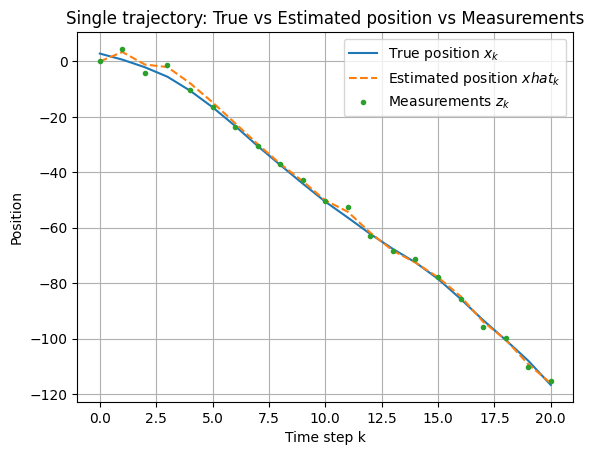

In [33]:
# ============================================================
# PART 1: Single trajectory plot
# ============================================================

# ----------------------------
# Step 4) Generate one trajectory + measurements
# ----------------------------
x_true, z_meas = simulate_trajectory(T, F, H, Q, R, mu0, P0, rng)

# ----------------------------
# Step 5) Run Kalman filter
# ----------------------------
x_hat, P_hist = kalman_filter(z_meas, F, H, Q, R, mu0, P0)

# ----------------------------
# Step 6) Plot true position, estimated position, measurements
# ----------------------------
k_axis = np.arange(T + 1)

plt.figure()
plt.plot(k_axis, x_true[:, 0], label="True position $x_k$")
plt.plot(k_axis, x_hat[:, 0], "--", label="Estimated position $xhat_k$")
plt.plot(k_axis, z_meas, ".", label="Measurements $z_k$")
plt.grid(True)
plt.xlabel("Time step k")
plt.ylabel("Position")
plt.title("Single trajectory: True vs Estimated position vs Measurements")
plt.legend()
plt.show()

In Part 2, the goal is to evaluate performance statistically across many independent runs, as required by the question. Step 7 prepares arrays to accumulate squared errors and covariance traces over time. Step 8 repeats the simulation and filtering process for T_total=1000 different trajectories, computes the position-plus-velocity squared error at each time step, and also collects the trace of the filtered covariance matrix as a measure of uncertainty. Step 9 averages these accumulated values to obtain the empirical MSE(k) and the average trace(P_{k|k}). Step 10 plots both curves versus time, and Step 11 prints the final-step values, allowing us to compare how the theoretical uncertainty trend aligns with the observed estimation error trend across many trials.

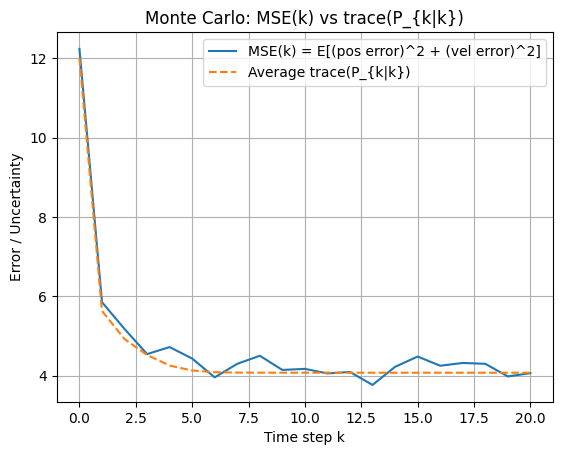

Final-step MSE(T): 4.063237783461392
Final-step trace(P): 4.075046650947542


In [30]:
# ============================================================
# PART 2: Monte Carlo MSE(k) and trace(P_k|k)
# ============================================================

# ----------------------------
# Step 7) Storage for MSE accumulation
# ----------------------------
pos_vel_sq_error_sum = np.zeros(T + 1)
traceP_sum = np.zeros(T + 1)

# ----------------------------
# Step 8) Loop over many trajectories
# ----------------------------
for j in range(T_total):
    x_true_j, z_j = simulate_trajectory(T, F, H, Q, R, mu0, P0, rng)
    x_hat_j, P_j = kalman_filter(z_j, F, H, Q, R, mu0, P0)

    # squared error of position + velocity at each k
    err = x_true_j - x_hat_j  # (T+1,2)
    sq = err[:, 0]**2 + err[:, 1]**2
    pos_vel_sq_error_sum += sq

    # trace(P_k|k) = P11 + P22
    traceP = P_j[:, 0, 0] + P_j[:, 1, 1]
    traceP_sum += traceP

# ----------------------------
# Step 9) Compute averages
# ----------------------------
MSE = pos_vel_sq_error_sum / T_total
traceP_avg = traceP_sum / T_total

# ----------------------------
# Step 10) Plot MSE(k) and trace(P_k|k)
# ----------------------------
plt.figure()
plt.plot(k_axis, MSE, label="MSE(k) = E[(pos error)^2 + (vel error)^2]")
plt.plot(k_axis, traceP_avg, "--", label="Average trace(P_{k|k})")
plt.grid(True)
plt.xlabel("Time step k")
plt.ylabel("Error / Uncertainty")
plt.title("Monte Carlo: MSE(k) vs trace(P_{k|k})")
plt.legend()
plt.show()

# ----------------------------
# Step 11) Short console check
# ----------------------------
print("Final-step MSE(T):", MSE[-1])
print("Final-step trace(P):", traceP_avg[-1])